In [4]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset, get_dataset_split_names, DatasetDict
from tqdm import tqdm

sns.set_color_codes("colorblind")
sns.set_theme(style="darkgrid")
sns.set_context("talk")
tqdm.pandas()

# set font to times new roman for plots
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})

## Load Datasets

In [5]:
split_sample_size = None
label_title_padding = 10
study_pile = False
RECITATION_THRESHOLD = 10

In [6]:
memories_path = "usvsnsp/generation-semantic-filters"
intermediate_path = "usvsnsp/generation-semantic-intermediate-filters"
memories_dataset = DatasetDict()
pile_dataset = DatasetDict()
splits = [split for split in get_dataset_split_names(memories_path) if "deduped" in split] + get_dataset_split_names(intermediate_path)
splits = [split for split in splits if "deduped" in split]
print(splits)

['pile_deduped_1.4b', 'memories_deduped_410m', 'memories_deduped_1.4b', 'memories_deduped_6.9b', 'memories_deduped_1b', 'pile_deduped_410m', 'pile_deduped_2.8b', 'pile_deduped_160m', 'memories_deduped_12b', 'pile_deduped_6.9b', 'pile_deduped_1b', 'memories_deduped_70m', 'memories_deduped_2.8b', 'pile_deduped_12b', 'memories_deduped_160m', 'pile_deduped_70m', 'memories_deduped_12b.43000', 'memories_deduped_12b.103000', 'memories_deduped_12b.83000', 'memories_deduped_12b.63000', 'memories_deduped_12b.123000', 'memories_deduped_12b.23000']


In [7]:
print("Loading datasets...")
print(f"Split sample size: {split_sample_size}")

for split in tqdm(splits):
    model = split.split("_")[-1]
    checkpoint = int(split.split(".")[-1]) if split.split(".")[-1][1].isnumeric() else "Final"
    formatted_split_name = split.replace("memories_", "").replace("deduped_", "deduped.").replace("pile_", "")
    dataset_path = memories_path if checkpoint == "Final" else intermediate_path
    if "memories" in split: 
        continue # Don't load memories since they're unnecessary for the first part of the analysis
        memories_dataset[formatted_split_name] = load_dataset(dataset_path, split=f"{split}[:{split_sample_size}]" if split_sample_size else split)
    else:
        pile_dataset[formatted_split_name] = load_dataset(dataset_path, split=f"{split}[:{split_sample_size}]" if split_sample_size else split)

display(memories_dataset)
display(pile_dataset)

Loading datasets...
Split sample size: None


100%|██████████| 22/22 [04:36<00:00, 12.58s/it]


DatasetDict({
    
})

DatasetDict({
    deduped.1.4b: Dataset({
        features: ['sequence_id', 'tokens', 'text', 'is_incrementing', 'is_repeating', 'sequence_duplicates', 'max_frequency', 'avg_frequency', 'min_frequency', 'median_frequency', 'p25_frequency', 'p75_frequency', 'frequencies', 'nl_scores', '0_8_snowclones', '0_9_snowclones', '0_8_templates', '0_9_templates', 'huffman_coding_length', 'memorization_score', 'index', 'loss', 'prompt_perplexity', 'generation_perplexity', 'sequence_perplexity'],
        num_rows: 5000000
    })
    deduped.410m: Dataset({
        features: ['sequence_id', 'tokens', 'text', 'is_incrementing', 'is_repeating', 'sequence_duplicates', 'max_frequency', 'avg_frequency', 'min_frequency', 'median_frequency', 'p25_frequency', 'p75_frequency', 'frequencies', 'nl_scores', '0_8_snowclones', '0_9_snowclones', '0_8_templates', '0_9_templates', 'huffman_coding_length', 'memorization_score', 'index', 'loss', 'prompt_perplexity', 'generation_perplexity', 'sequence_perplexity'],
   

In [8]:
split_to_param_count = {
    "70m": 70000000,
    "160m": 160000000,
    "410m": 410000000,
    "1b": 1000000000,
    "1.4b": 1400000000,
    "2.8b": 2800000000,
    "6.9b": 6900000000,
    "12b": 12000000000,
}

In [9]:
def get_frame_from_split(dataset, split_name, is_pile_sample):
    current_frame = dataset[split].to_pandas()
    current_frame.drop(columns=columns_to_drop, inplace=True)
    checkpoint = int(split.split(".")[-1]) if split.split(".")[-1][1].isnumeric() and len(split.split(".")) != 2 else "Final"
    current_frame["Checkpoint"] = checkpoint
    model = split.split("deduped")[-1][1:] if checkpoint == "Final" else split.split(".")[-2]
    current_frame["Model"] = model
    current_frame["Param Count"] = split_to_param_count[current_frame["Model"].iloc[0]]
    current_frame["Deduped"] = "deduped" in split
    current_frame["Memorized"] = current_frame["memorization_score"] >= 1
    current_frame["IsPileSample"] = is_pile_sample
    return current_frame


columns_to_drop = ["frequencies", "tokens", "text"]
combined_dataframe = None
for split in tqdm(memories_dataset, desc="Loading Memories"):
    current_frame = get_frame_from_split(memories_dataset, split, False)
    if combined_dataframe is None:
        combined_dataframe = current_frame
    else:
        combined_dataframe = pd.concat([combined_dataframe, current_frame])

for split in tqdm(pile_dataset, desc="Loading Pile"):
    current_frame = get_frame_from_split(pile_dataset, split, True)
    combined_dataframe = pd.concat([combined_dataframe, current_frame])

combined_dataframe = combined_dataframe.sort_values("Param Count")
# display(combined_dataframe.shape)
# display(combined_dataframe.columns)
combined_dataframe

Loading Memories: 0it [00:00, ?it/s]
Loading Pile: 100%|██████████| 8/8 [01:48<00:00, 13.51s/it]


,sequence_id,is_incrementing,is_repeating,sequence_duplicates,max_frequency,avg_frequency,min_frequency,median_frequency,p25_frequency,p75_frequency,...,loss,prompt_perplexity,generation_perplexity,sequence_perplexity,Checkpoint,Model,Param Count,Deduped,Memorized,IsPileSample
4999999,146403638,False,False,1,10346382453,1.676912e+09,1462435,42754129.0,9112132,1728418100,...,3.712891,5.739519,9.374301,53.803978,Final,70m,70000000,True,False,True
1666661,50421451,False,False,2,11740996961,1.120673e+09,1265958,23516309.5,12840362,252804149,...,3.748047,16.159386,11.689136,188.889236,Final,70m,70000000,True,False,True
1666662,50421998,False,False,1,11740996961,1.196123e+09,384189,17048438.0,1897107,203866459,...,3.666016,6.101375,6.676538,40.736057,Final,70m,70000000,True,False,True
1666663,50422124,False,False,1,11740996961,2.443983e+09,746870,199779094.0,3318890,1879045405,...,3.699219,4.461984,3.711028,16.558550,Final,70m,70000000,True,False,True
1666664,50424046,False,False,2,11740996961,3.002466e+09,816152,312686394.5,14683954,1659997854,...,3.625000,18.192390,3.591383,65.335831,Final,70m,70000000,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3333336,114109475,False,False,3,10346382453,1.659249e+09,1642892,122746407.0,5316161,1056564737,...,2.507812,3.680773,2.260911,8.321902,Final,12b,12000000000,True,False,True
3333337,114113573,False,False,2,9362638615,2.938379e+09,1260506,145471656.0,9625803,8485755698,...,2.421875,3.658763,3.240125,11.854851,Final,12b,12000000000,True,False,True
3333338,114114792,False,False,2,11740996961,1.891609e+09,1553227,355879143.0,13014911,675535746,...,2.466797,1.839900,1.685525,3.101197,Final,12b,12000000000,True,False,True
3333331,114087523,False,False,2,4746582725,7.599255e+08,602473,434885834.0,12909646,892362978,...,2.613281,7.184592,5.081010,36.504986,Final,12b,12000000000,True,False,True


## Assign Examples to Taxonomy

In [10]:
def get_category(row):
    if row["Memorized"] == False:
        return "Not Memorized"
    if row["sequence_duplicates"] >= RECITATION_THRESHOLD:
        return "Recitation"
    if row["is_incrementing"] or row["is_repeating"]:
        return "Reconstruction"

    return "Recollection"

combined_dataframe["category"] = combined_dataframe.progress_apply(lambda row: get_category(row), axis=1)
combined_dataframe.value_counts(["Model", "Checkpoint", "category"])

100%|██████████| 40000000/40000000 [01:28<00:00, 451865.61it/s]


Model  Checkpoint  category      
70m    Final       Not Memorized     4990571
160m   Final       Not Memorized     4985999
410m   Final       Not Memorized     4979577
1b     Final       Not Memorized     4973065
1.4b   Final       Not Memorized     4972518
2.8b   Final       Not Memorized     4962857
6.9b   Final       Not Memorized     4952353
12b    Final       Not Memorized     4946005
                   Recitation          41880
6.9b   Final       Recitation          37221
2.8b   Final       Recitation          28865
1.4b   Final       Recitation          21300
1b     Final       Recitation          20971
410m   Final       Recitation          15792
12b    Final       Recollection        11130
160m   Final       Recitation          10827
6.9b   Final       Recollection         9478
70m    Final       Recitation           7514
2.8b   Final       Recollection         7362
1.4b   Final       Recollection         5326
1b     Final       Recollection         5105
410m   Final       Re

## Plot Graphs

## Figure: Perplexity and Duplication

generation_perplexity                                          \
                          count      mean       std       min       25%   
Memorized                                                                 
False                 3623846.0  3.348701  1.628455  1.008704  2.249641   
True                    51791.0  1.017985  0.022474  1.000001  1.002654   

                                          
                50%       75%        max  
Memorized                                 
False      3.134632  4.112053  79.729668  
True       1.010172  1.025033   1.892449

,sequence_id,is_incrementing,is_repeating,sequence_duplicates,max_frequency,avg_frequency,min_frequency,median_frequency,p25_frequency,p75_frequency,...,prompt_perplexity,generation_perplexity,sequence_perplexity,Checkpoint,Model,Param Count,Deduped,Memorized,IsPileSample,category
2,5340,False,False,2,2965935634,1.792402e+08,399060,25183055.0,5176365,61384386,...,4.416619,2.464730,10.885771,Final,12b,12000000000,True,False,True,Not Memorized
3,7312,False,False,2,11740996961,2.152746e+09,627945,229843255.5,10479427,3312842838,...,9.213257,4.078539,37.576630,Final,12b,12000000000,True,False,True,Not Memorized
1666664,50424046,False,False,2,11740996961,3.002466e+09,816152,312686394.5,14683954,1659997854,...,8.756902,1.888000,16.533028,Final,12b,12000000000,True,False,True,Not Memorized
1666665,50424970,False,False,2,11740996961,1.539308e+09,292565,188282139.0,12313079,615893065,...,3.119205,1.388903,4.332273,Final,12b,12000000000,True,False,True,Not Memorized
1666666,50426594,False,False,2,10346382453,1.352726e+09,279665,59189898.0,9351311,577423529,...,5.794797,3.105920,17.998175,Final,12b,12000000000,True,False,True,Not Memorized
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3333336,114109475,False,False,3,10346382453,1.659249e+09,1642892,122746407.0,5316161,1056564737,...,3.680773,2.260911,8.321902,Final,12b,12000000000,True,False,True,Not Memorized
3333337,114113573,False,False,2,9362638615,2.938379e+09,1260506,145471656.0,9625803,8485755698,...,3.658763,3.240125,11.854851,Final,12b,12000000000,True,False,True,Not Memorized
3333338,114114792,False,False,2,11740996961,1.891609e+09,1553227,355879143.0,13014911,675535746,...,1.839900,1.685525,3.101197,Final,12b,12000000000,True,False,True,Not Memorized
3333331,114087523,False,False,2,4746582725,7.599255e+08,602473,434885834.0,12909646,892362978,...,7.184592,5.081010,36.504986,Final,12b,12000000000,True,False,True,Not Memorized


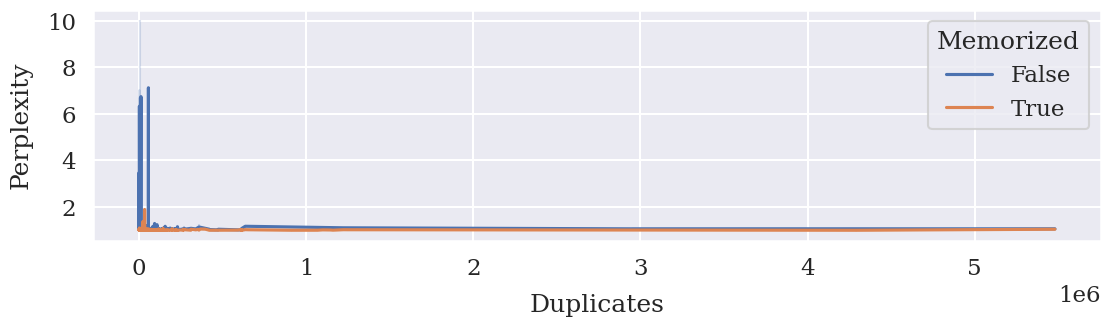

In [11]:
# line plot where sequence_duplicates is the x axis and the y axis is the generation_perplexity
deduped_12b = combined_dataframe[
    (combined_dataframe["Model"] == "12b") & (combined_dataframe["Checkpoint"] == "Final") & (combined_dataframe["Deduped"] == True) & (combined_dataframe["IsPileSample"] == True)
]
# deduped_12b = deduped_12b[deduped_12b["category"] != "Reconstruction"]
deduped_12b = deduped_12b[deduped_12b["sequence_duplicates"] >= 2]
display(deduped_12b[["Memorized", "generation_perplexity"]].groupby("Memorized").describe())

display(deduped_12b)

# Plot lineplot
sns.lineplot(data=deduped_12b, x="sequence_duplicates", y="generation_perplexity", hue="Memorized", errorbar="ci")

# y label is "Perplexity" and x label is "Duplicates"
plt.xlabel("Duplicates", labelpad=label_title_padding)
plt.ylabel("Perplexity", labelpad=label_title_padding)

# set figure dimensions
plt.gcf().set_size_inches(13, 3)

# log x axis
# plt.xscale("log")

In [12]:
max_memorized_perplexity = deduped_12b[deduped_12b["Memorized"] == False]["generation_perplexity"].mean()
max_memorized_perplexity

3.3487005

In [13]:
examples_below_ppl_thrrshold = deduped_12b[deduped_12b["generation_perplexity"] <= max_memorized_perplexity]
examples_below_ppl_thrrshold.value_counts("Memorized", normalize=True)

Memorized
False    0.975207
True     0.024793
Name: proportion, dtype: float64

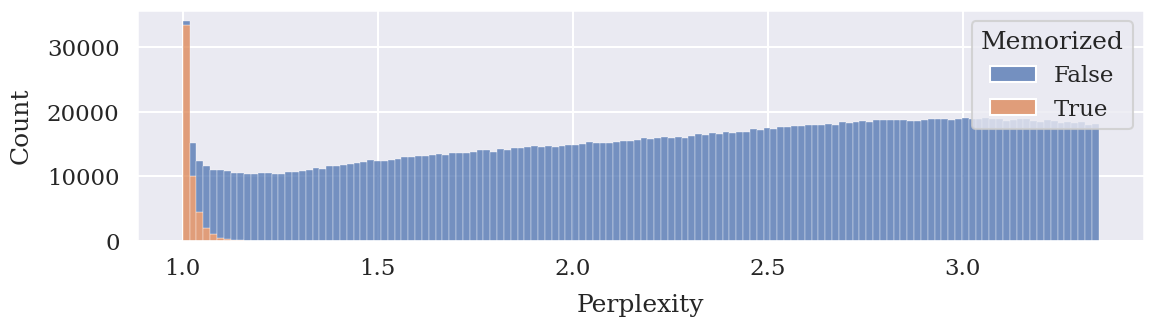

In [14]:
hist_data_12b = deduped_12b[deduped_12b["generation_perplexity"] <= max_memorized_perplexity].copy()
# hist_data_12b = hist_data_12b[hist_data_12b["category"] != "Reconstruction"]
sns.histplot(data=hist_data_12b, x="generation_perplexity", hue="Memorized", multiple="stack")

plt.xlabel("Perplexity", labelpad=label_title_padding)
plt.ylabel("Count", labelpad=label_title_padding)
plt.gcf().set_size_inches(13, 3)
sns.move_legend(plt.gca(), "upper right")

In [15]:
# value counts in percent of Memorized
deduped_12b["Memorized"].value_counts(normalize=True)

Memorized
False    0.98591
True     0.01409
Name: proportion, dtype: float64

In [16]:
# deduped_12b where memorization_scorem == 1 and Memorized = True
memorized_False = len(deduped_12b[(deduped_12b["Memorized"] == False)])
false_with_score_1 = len(deduped_12b[(deduped_12b["Memorized"] == False) & (deduped_12b["memorization_score"] == 1)])
print(f"False with score 1: {false_with_score_1} / {memorized_False} = {100 * false_with_score_1 / memorized_False}")

False with score 1: 0 / 3623846 = 0.0


In [17]:
# get mean and std dev for each bucket
duplication_ppl_stats = deduped_12b.groupby(["sequence_duplicates", "Distribution"]).agg({"generation_perplexity": ["mean", "std"]})
# display the entire frame

display(duplication_ppl_stats)
duplication_ppl_stats.to_csv("duplication_ppl_stats.csv")

KeyError: 'Distribution'

In [ ]:
combined_memories_dataframe = combined_dataframe[combined_dataframe["Memorized"] == True]
combined_memories_dataframe

### Figure: Count and Memories by Taxonomy Across Time and Scale

In [ ]:
# Create plot for data across 
final_checkpoint_counts_frame = combined_memories_dataframe[combined_memories_dataframe["Checkpoint"] == "Final"].value_counts(["Param Count", "category"]).unstack().reindex(split_to_param_count.values())
final_checkpoint_counts_frame.to_csv(f"final_checkpoint_counts_recitation={RECITATION_THRESHOLD}.csv")
display(final_checkpoint_counts_frame)

intermediate_frame = combined_memories_dataframe[(combined_memories_dataframe["Checkpoint"] != "Final") & (combined_memories_dataframe["Model"] == "12b")]
sorted_checkpoints = sorted(intermediate_frame["Checkpoint"].unique(), key=lambda x: int(x))

intermediate_checkpoint_counts_frame = intermediate_frame.value_counts(["Checkpoint", "category"]).unstack().reindex(sorted_checkpoints)
intermediate_checkpoint_counts_frame.to_csv(f"intermediate_checkpoint_counts_recitation={RECITATION_THRESHOLD}.csv")
display(intermediate_checkpoint_counts_frame)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(13, 3))

# set figure 1
# first figure is a line plot of the counts of each category for across intermediate checkpoints

sns.lineplot(ax=axes[0], data=intermediate_checkpoint_counts_frame, dashes=False, markers=True, markersize=8)

# rotate x axis labels
# axes[0].tick_params(axis='x', rotation=20)

# make x labels smaller
axes[0].tick_params(axis='x', labelsize=12)

# Add y label for Count
axes[0].set_ylabel("Count", labelpad=label_title_padding)

# add padding for labels
fig.subplots_adjust(wspace=0.2)

# make x and y axis log scale
axes[0].set_yscale("log")

# # have a common legend for both plots centered below the figure. No legend box
axes[0].legend(loc='upper center', bbox_to_anchor=(1.1, -0.3), ncol=4, frameon=False)

# set figure 2
# the second figure is a line plot of the counts of each category across parameter count

sns.lineplot(ax=axes[1], data=final_checkpoint_counts_frame, dashes=False, markers=True, markersize=8)

# make x and y axis log scale
axes[1].set_xscale("log")
axes[1].set_yscale("log")

# Set x label to "Parameters"
axes[1].set_xlabel("Parameters")

# Add y label for Count
axes[1].set_ylabel("Count")

# remove legend
axes[1].legend().remove()

# add padding for labels
fig.subplots_adjust(wspace=0.30)

fig.savefig(f"categories_counts_across_time+scale_recitation={RECITATION_THRESHOLD}.png", bbox_inches="tight")



### Figure: Percents and Memories by Taxonomy Across Time and Scale

In [ ]:
counts_frame = combined_memories_dataframe.value_counts(["Param Count", "category"]).unstack().reindex(split_to_param_count.values())
display(counts_frame)

In [ ]:
sorted_checkpoints = [23000, 43000, 63000, 83000, 103000, 123000]
assert len(sorted_checkpoints) + 1 == len(combined_memories_dataframe[(combined_memories_dataframe["Model"] == "12b") & (combined_memories_dataframe["Deduped"] == True)]["Checkpoint"].unique())

all_percents_time = []
for checkpoint in tqdm(sorted_checkpoints):
    model_examples = combined_memories_dataframe[combined_memories_dataframe["Checkpoint"] == checkpoint]
    model_percents = model_examples.value_counts("category", normalize=True).to_dict()
    for category in model_percents:
        all_percents_time.append({
            "Checkpoint": checkpoint,
            "category": category,
            "percent": model_percents[category],
        })

percents_frame_time = pd.DataFrame(all_percents_time).pivot(index="Checkpoint", columns="category", values="percent").reindex(sorted_checkpoints)
percents_frame_time.to_csv(f"percents_frame_time_recitation={RECITATION_THRESHOLD}.csv")
display(percents_frame_time)

In [ ]:
all_percents_scale = []
for param_count in tqdm(split_to_param_count.values()):
    model_examples = combined_memories_dataframe[combined_memories_dataframe["Param Count"] == param_count]
    model_percents = model_examples.value_counts("category", normalize=True).to_dict()
    for category in model_percents:
        all_percents_scale.append({
            "Model": model_examples["Model"].unique()[0],
            "Param Count": param_count,
            "category": category,
            "percent": model_percents[category],
        })

percents_frame_scale = pd.DataFrame(all_percents_scale).pivot(index="Model", columns="category", values="percent").reindex(split_to_param_count.keys())
percents_frame_scale.to_csv(f"percents_frame_scale_recitation={RECITATION_THRESHOLD}.csv")
display(percents_frame_scale)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(13, 3))
plots = [
    (percents_frame_time, axes[0]),
    (percents_frame_scale, axes[1])
]

for idx, (data, ax) in enumerate(plots):
    data.plot.bar(
        stacked=True,
        ax=ax,
        rot=0,
        width=1,
        ylabel="Memories",
    )

    if idx == 0:
        ax.set_xlabel("Checkpoint")
    else:
        ax.set_xlabel("Parameter Count")
    
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}%".format(int(x * 100))))
    ax.tick_params(axis='x', rotation=20, labelsize=12)
    ax.get_legend().remove()

# Adjusting subplot parameters
fig.subplots_adjust(wspace=0.30)

# Common legend configuration
axes[0].legend(loc='upper center', bbox_to_anchor=(1.1, -0.4), ncol=4, frameon=False)

# Save the figure
fig.savefig(f"categories_percents_across_time+scale_recitation={RECITATION_THRESHOLD}.png", bbox_inches="tight")
